# 0) Modules & Functions

In [43]:
import os
import pandas as pd
from rdkit import Chem
import subprocess
import hashlib
import tempfile
import base64
import numpy as np
from itertools import combinations
from scipy.stats import pearsonr
from tqdm import tqdm
import time
from collections import defaultdict
from rdkit.Chem import AllChem
from rdkit import RDLogger
import warnings
import re
from rdkit.Chem import inchi
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from rdkit.Chem import Descriptors

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

warnings.filterwarnings("ignore", category=UserWarning, module="rdkit")
warnings.filterwarnings("ignore", category=FutureWarning, module="rdkit")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="rdkit")

class MMPGenerator:
    def __init__(self, df_input, output_csv, mmpa_dir='../mmpa',
                 symmetric=True, max_heavy=14, max_ratio=0.7, verbose=True):
        self.df_original = df_input.copy()
        self.output_csv = output_csv
        self.mmpa_dir = mmpa_dir
        self.symmetric = symmetric
        self.max_heavy = max_heavy
        self.max_ratio = max_ratio
        self.verbose = verbose

    def _get_inchikey(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.inchi.MolToInchiKey(mol)
        return self.encode_string(smiles)

    def encode_string(self, s):
        return base64.urlsafe_b64encode(s.encode()).decode()

    def decode_string(self, b64):
        return base64.urlsafe_b64decode(b64.encode()).decode()

    def run(self):
        self.df_original['ID'] = [self._get_inchikey(smi) for smi in self.df_original['SMILES']]
        y_map = self.df_original.set_index('ID')['Y'].to_dict()

        with tempfile.TemporaryDirectory() as tmp:
            smi_path = os.path.join(tmp, 'input.smi')
            frag_path = os.path.join(tmp, 'fragmented.txt')
            mmps_path = os.path.join(tmp, 'mmps.csv')
            smirks_path = os.path.join(tmp, 'smirks.txt')
            cansmirks_path = os.path.join(tmp, 'cansmirks.txt')

            self.df_original[['SMILES', 'ID']].to_csv(smi_path, index=False, sep=' ', header=False)

            print("0) Fragments generation")
            with open(frag_path, 'w') as out:
                subprocess.run(['python', f'{self.mmpa_dir}/rfrag.py'], stdin=open(smi_path), stdout=out)

            print("1) Indexing")
            cmd = ['python', f'{self.mmpa_dir}/indexing.py']
            if self.symmetric:
                cmd.append('-s')
            if self.max_heavy:
                cmd.extend(['-m', str(self.max_heavy)])
            if self.max_ratio:
                cmd.extend(['-r', str(self.max_ratio)])

            with open(mmps_path, 'w') as out:
                subprocess.run(cmd, stdin=open(frag_path), stdout=out)

            with open(mmps_path) as f:
                lines = [line.strip() for line in f if line.strip()]


            splits = [line.split(',') for line in lines]
            max_len = max(len(s) for s in splits)

            df = pd.DataFrame(splits, columns=['L_SMILES', 'R_SMILES', 'L_ID', 'R_ID', 'SMIRKS', 'CORE'])


            df['L_Y'] = df['L_ID'].map(y_map)
            df['R_Y'] = df['R_ID'].map(y_map)
            df['Delta_Y'] = df['R_Y'] - df['L_Y']

            df = df[df['SMIRKS'].apply(lambda x: isinstance(x, str) and '>>' in x)]

            df['__row'] = range(len(df))
            df[['SMIRKS', '__row']].to_csv(smirks_path, index=False, sep=' ', header=False)

            print("2) Canonical SMIRKS generation")
            with open(cansmirks_path, 'w') as out:
                subprocess.run(['python', f'{self.mmpa_dir}/cansmirk.py'], stdin=open(smirks_path), stdout=out)


            canon_df = pd.read_csv(cansmirks_path, sep=' ', names=['Canonical_SMIRKS', 'index'])


            df = df.merge(canon_df, left_on='__row', right_on='index').drop(columns=['__row', 'index'])

            df[['L_sub', 'R_sub']] = df['Canonical_SMIRKS'].str.split('>>', expand=True)


            df['L_sub_ID'] = [self.encode_string(k) for k in df['L_sub'].tolist()]
            df['R_sub_ID'] = [self.encode_string(k) for k in df['R_sub'].tolist()]
            df['SMIRKS_ID'] = [self.encode_string(k) for k in df['Canonical_SMIRKS'].tolist()]
            df['CORE_ID'] = [self.encode_string(k) for k in df['CORE'].tolist()]
            df = df.drop_duplicates()


            df[['L_SMILES', 'R_SMILES', 'L_ID', 'R_ID', 'SMIRKS', 'CORE', 'L_Y', 'R_Y', 'Delta_Y', 'L_sub', 'R_sub', 'L_sub_ID', 'R_sub_ID', 'SMIRKS_ID', 'CORE_ID']].to_csv(
                self.output_csv, index=False
            )


class MMPAugmentorFixed:
    def __init__(self, df, min_common=4, pearson_thresh=0.3, crmsd_thresh=0.4):
        self.df = df.copy()
        self.min_common = min_common
        self.pearson_thresh = pearson_thresh
        self.crmsd_thresh = crmsd_thresh
        self.series = {}
        self.pair_scores = []
        self.filtered_pairs = []
        self.augmented_data = []

    def _extract_series(self):
        start = time.time()
        self.series = {
            core: group for core, group in self.df.groupby("CORE")
        }

    def _compute_pairwise_scores(self):
        start = time.time()
        self.pair_scores = []
        series_items = list(self.series.items())
        total_combinations = len(series_items) * (len(series_items) - 1) // 2
        for (core1, df1), (core2, df2) in tqdm(combinations(series_items, 2), desc="3) Computing pairwise correlations", total=total_combinations):
            subs1 = set(df1["L_sub"])
            subs2 = set(df2["L_sub"])
            common = subs1 & subs2
            if len(common) < self.min_common:
                continue

            merged = pd.merge(
                df1, df2,
                left_on=["L_sub", "R_sub"],
                right_on=["L_sub", "R_sub"],
                suffixes=('_1', '_2')
            )
            if len(merged) < self.min_common:
                continue

            y1 = merged['Delta_Y_1'].values
            y2 = merged['Delta_Y_2'].values
            crmsd = np.sqrt(np.mean((y1 - y2) ** 2))
            try:
                corr = pearsonr(y1, y2)[0]
            except:
                corr = np.nan

            self.pair_scores.append((core1, core2, crmsd, corr, len(merged)))

    def _filter_pairs(self):
        start = time.time()
        self.filtered_pairs = [
            (s1, s2) for s1, s2, rmsd, corr, n in self.pair_scores
            if rmsd <= self.crmsd_thresh and (not np.isnan(corr) and corr >= self.pearson_thresh)
        ]

    def _augment(self):
        start = time.time()
        augmented_entries = []

        for s1, s2 in tqdm(self.filtered_pairs, desc="4) Augmenting data"):
            df1 = self.series[s1]
            df2 = self.series[s2]

            tf1 = df1[["L_sub", "R_sub", "Delta_Y"]].to_dict("records")
            tf2 = df2[["L_sub", "R_sub", "Delta_Y"]].to_dict("records")

            df1_dict = defaultdict(list)
            for _, row in df1.iterrows():
                df1_dict[row["L_sub"]].append(row.to_dict())

            df2_dict = defaultdict(list)
            for _, row in df2.iterrows():
                df2_dict[row["L_sub"]].append(row.to_dict())

            for entry in tf1:
                l_sub = entry["L_sub"]
                for base in df2_dict.get(l_sub, []):
                    r_sub = entry["R_sub"]
                    delta = entry["Delta_Y"]
                    new_y = base["L_Y"] + delta
                    smirks_new = l_sub + ">>" + r_sub
                    augmented_entries.append({
                        "CORE": s1,
                        "L_sub": l_sub,
                        "R_sub": r_sub,
                        "L_Y": base["L_Y"],
                        "R_Y": new_y,
                        "Delta_Y": delta,
                        "AUG": True,
                        "L_SMILES": base.get("L_SMILES"),
                        "L_ID": base.get("L_ID"),
                        "L_sub_ID": base.get("L_sub_ID"),
                        "R_sub_ID": base64.urlsafe_b64encode(r_sub.encode()).decode(),
                        "SMIRKS": smirks_new,
                        "SMIRKS_ID": base64.urlsafe_b64encode(smirks_new.encode()).decode(),
                        "CORE_ID": base64.urlsafe_b64encode(s1.encode()).decode()
                    })

            for entry in tf2:
                l_sub = entry["L_sub"]
                for base in df1_dict.get(l_sub, []):
                    r_sub = entry["R_sub"]
                    delta = entry["Delta_Y"]
                    new_y = base["L_Y"] + delta
                    smirks_new = l_sub + ">>" + r_sub
                    augmented_entries.append({
                        "CORE": s2,
                        "L_sub": l_sub,
                        "R_sub": r_sub,
                        "L_Y": base["L_Y"],
                        "R_Y": new_y,
                        "Delta_Y": delta,
                        "AUG": True,
                        "L_SMILES": base.get("L_SMILES"),
                        "L_ID": base.get("L_ID"),
                        "L_sub_ID": base.get("L_sub_ID"),
                        "R_sub_ID": base64.urlsafe_b64encode(r_sub.encode()).decode(),
                        "SMIRKS": smirks_new,
                        "SMIRKS_ID": base64.urlsafe_b64encode(smirks_new.encode()).decode(),
                        "CORE_ID": base64.urlsafe_b64encode(s2.encode()).decode()
                    })

        self.augmented_data = pd.DataFrame(augmented_entries)


    def run(self):
        self._extract_series()
        self._compute_pairwise_scores()
        self._filter_pairs()
        self._augment()

        original = self.df.copy()
        original["AUG"] = False
        return pd.concat([original, self.augmented_data], ignore_index=True)
    
    def get_pair_scores_df(self):
        """
        Return a DataFrame of scaffold pair scores (cRMSD, Pearson, common MMP count)
        """
        return pd.DataFrame(
            self.pair_scores,
            columns=["Scaffold_1", "Scaffold_2", "cRMSD", "Pearson", "N_common"]
        )

    def get_augmented_only(self):
        """
        Return only the augmented (predicted) entries.
        """
        return self.augmented_data.copy()
    

def analyze_scaffold_pair_scores(df):
    summary = {
        "Total Pairs": len(df),
        "Mean cRMSD": df["cRMSD"].mean(),
        "Median cRMSD": df["cRMSD"].median(),
        "Std cRMSD": df["cRMSD"].std(),
        "Mean Pearson": df["Pearson"].mean(),
        "Median Pearson": df["Pearson"].median(),
        "Std Pearson": df["Pearson"].std(),
        "Mean N_common": df["N_common"].mean(),
        "Median N_common": df["N_common"].median()
    }

    high_corr = df["Pearson"] > 0.7
    low_crmsd = df["cRMSD"] < 0.5
    enough_common = df["N_common"] >= 5
    strong_pairs = df[high_corr & low_crmsd & enough_common]

    summary.update({
        "High Pearson (>0.7)": high_corr.sum(),
        "Low cRMSD (<0.5)": low_crmsd.sum(),
        "N_common ≥ 5": enough_common.sum(),
        "Strong Pairs (all 3)": len(strong_pairs)
    })

    top_corr = df.sort_values("Pearson", ascending=False).head(5)
    top_low_crmsd = df.sort_values("cRMSD").head(5)
    top_common = df.sort_values("N_common", ascending=False).head(5)

    return {
        "summary": summary,
        "top_corr": top_corr,
        "top_low_crmsd": top_low_crmsd,
        "top_common": top_common,
        "strong_pairs": strong_pairs
    }




def fast_apply_transformation(transformation, l_smiles, rxn_cache, core_cache, heavy_cache, core_smarts, failure_tracker=None):
    if pd.isna(transformation) or pd.isna(l_smiles):
        return None

    # --- Cache reaction and Δheavy ---
    if transformation not in rxn_cache:
        try:
            rxn = AllChem.ReactionFromSmarts(transformation)
            left_smi, right_smi = transformation.split(">>")
            left_mol = Chem.MolFromSmarts(left_smi)
            right_mol = Chem.MolFromSmarts(right_smi)
            delta_heavy = right_mol.GetNumHeavyAtoms() - left_mol.GetNumHeavyAtoms()
            rxn_cache[transformation] = (rxn, delta_heavy)
        except:
            return None
    else:
        rxn, delta_heavy = rxn_cache[transformation]

    # --- Cache L_SMILES heavy atom count ---
    if l_smiles not in heavy_cache:
        mol_l = Chem.MolFromSmiles(l_smiles)
        if mol_l is None:
            return None
        n_heavy_l = mol_l.GetNumHeavyAtoms()
        heavy_cache[l_smiles] = (mol_l, n_heavy_l)
    else:
        mol_l, n_heavy_l = heavy_cache[l_smiles]

    # --- Cache core mol ---
    if core_smarts not in core_cache:
        core_mol = Chem.MolFromSmarts(core_smarts)
        if core_mol is None:
            return None
        core_cache[core_smarts] = core_mol
    else:
        core_mol = core_cache[core_smarts]

    # --- Run reaction ---
    try:
        products = rxn.RunReactants((mol_l,))
    except Exception:
        return None

    if failure_tracker is not None:
        failure_tracker["total"] += 1
        if not products:
            failure_tracker["empty_prodsets"] += 1

    all_products = []
    for prod_set in products:
        if not prod_set and failure_tracker is not None:
            failure_tracker["empty_prodsets"] += 1
        for prod in prod_set:
            if prod is None:
                continue
            try:
                if not prod.HasSubstructMatch(core_mol):
                    continue
            except:
                continue
            n_heavy_r = prod.GetNumHeavyAtoms()
            if n_heavy_r - n_heavy_l != delta_heavy:
                continue
            all_products.append(Chem.MolToSmiles(prod, isomericSmiles=True))

    return all_products if all_products else None

def update_predicted_rows(df):
    df = df.drop_duplicates()
    mask = df["AUG"] == True
    indices = df[mask].index

    rxn_cache = {}
    heavy_cache = {}
    core_cache = {}

    new_rows = []
    failure_tracker = {"total": 0, "empty_prodsets": 0}

    for idx in tqdm(indices, desc="5) Updating predicted rows"):
        row = df.loc[idx]
        l_smiles = row["L_SMILES"]
        smirks = row["SMIRKS"]
        core = row["CORE"]

        r_smiles_list = fast_apply_transformation(
            smirks, l_smiles, rxn_cache, core_cache, heavy_cache, core,
            failure_tracker=failure_tracker
        )

        if r_smiles_list:
            for r_smiles in r_smiles_list:
                mol = Chem.MolFromSmiles(r_smiles)
                if mol:
                    r_id = Chem.InchiToInchiKey(Chem.MolToInchi(mol))
                    new_row = row.copy()
                    new_row["R_SMILES"] = r_smiles
                    new_row["R_ID"] = r_id
                    new_rows.append(new_row)

    df_non_aug = df[~mask]
    df_aug_expanded = pd.DataFrame(new_rows)
    df_final = pd.concat([df_non_aug, df_aug_expanded], ignore_index=True)

    # Print failure rate
    total = failure_tracker["total"]
    failed = failure_tracker["empty_prodsets"]
    if total > 0:
        print(f"⚠️  Empty product sets in {failed} / {total} ({100 * failed / total:.2f}%) of transformations")

    return df_final








def prepare_and_plot_prediction_vs_experiment_complete_with_output(imputed_df, std_threshold=0.5):

    print("6) Preparing output file")

    l_df = imputed_df[["L_SMILES", "L_Y", "AUG"]]
    r_df = imputed_df[["R_SMILES", "R_Y", "AUG"]]
    l_df.columns = ["SMILES", "Y", "AUG"]
    r_df.columns = ["SMILES", "Y", "AUG"]
    clean_df = pd.concat([l_df, r_df])


    # Count total before
    total_before = len(clean_df)

    # Drop rows with missing or invalid SMILES
    clean_df = clean_df.dropna(subset=["SMILES"]).copy()
    clean_df = clean_df[clean_df["SMILES"].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

    # Count total after
    total_after = len(clean_df)

    # Print failure rate
    fail_pct = 100 * (total_before - total_after) / total_before
    print(f"Invalid SMILES removed: {total_before - total_after} / {total_before} ({fail_pct:.2f}%)")

    tqdm.pandas(desc="7) Standardizing SMILES")
    clean_df["SMILES"] = clean_df["SMILES"].progress_apply(
        lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=True)
    )

    # Step 8) InChIKey generation
    tqdm.pandas(desc="8) Generating InChIKeys")
    clean_df['InChIKey'] = clean_df["SMILES"].progress_apply(smiles_to_inchikey)


    # Insert InChIKey as first column
    cols = ['InChIKey'] + [col for col in clean_df.columns if col != 'InChIKey']
    clean_df = clean_df[cols]


    clean_df_exp = clean_df[clean_df["AUG"] != True].copy()
    clean_df_pred = clean_df[clean_df["AUG"] == True].copy()

    # Normalize column names
    clean_df_exp = clean_df_exp.rename(columns={"R_SMILES": "SMILES", "R_Y": "Y"})
    clean_df_pred = clean_df_pred.rename(columns={"R_SMILES": "SMILES", "R_Y": "Y"})

    # Compute median and std per SMILES in predicted
    grouped_pred = clean_df_pred.groupby("InChIKey")["Y"].agg(["median", "std"]).reset_index()
    grouped_pred.columns = ["InChIKey", "Y", "STD"]
    grouped_pred["AUG"] = True

    # Re-add SMILES by mapping InChIKey → first SMILES in original pred dataframe
    inchikey_to_smiles = clean_df_pred.dropna(subset=["SMILES"]).drop_duplicates("InChIKey").set_index("InChIKey")["SMILES"].to_dict()
    grouped_pred["SMILES"] = grouped_pred["InChIKey"].map(inchikey_to_smiles)
    grouped_pred = grouped_pred[["InChIKey", "SMILES", "Y", "STD", "AUG"]]
    grouped_pred = grouped_pred[grouped_pred["STD"]<= std_threshold]

    # Final prediction rows
    exp_out = clean_df_exp[['InChIKey', "SMILES", "Y"]].copy()
    exp_out["STD"] = None
    exp_out["AUG"] = False
    exp_out = exp_out[["InChIKey", "SMILES", "Y", "STD", "AUG"]]

    exp_out = exp_out.dropna(how='all')
    grouped_pred = grouped_pred.dropna(how='all')

    # Remove predicted entries with InChIKey already in experimental
    known_keys = set(exp_out['InChIKey'])
    grouped_pred = grouped_pred[~grouped_pred['InChIKey'].isin(known_keys)]


    output_df = pd.concat(
    [exp_out.drop_duplicates("InChIKey"), grouped_pred.drop_duplicates("InChIKey")],
    ignore_index=True
    )

    output_df = output_df[~((output_df['AUG'] == True) & (output_df['InChIKey'].isin(output_df.loc[output_df['AUG'] == False, 'InChIKey'])))]

    return output_df


# Compute InChIKey from SMILES
def smiles_to_inchikey(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        return inchi.MolToInchiKey(mol)
    except:
        return None
    

def assign_set_from_inchikey(output_df, reference_df, smiles_col="SMILES", inchikey_col="InChIKey", set_col="SET"):
    # Compute InChIKey for each SMILES in output_df
    output_df[inchikey_col] = output_df[smiles_col].apply(
        lambda smi: Chem.inchi.MolToInchiKey(Chem.MolFromSmiles(smi)) if Chem.MolFromSmiles(smi) else None
    )
    
    # Create lookup from reference_df
    inchikey_map = dict(zip(reference_df[inchikey_col], reference_df[set_col]))
    
    # Map SET
    output_df[set_col] = output_df[inchikey_col].map(inchikey_map)
    
    return output_df


def smiles_to_morgan(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits))

def train_and_compare_models(output_df, random_state=29121997):
    print("🔬 Starting model training and comparison...")

    # --- Step 1: Compute Morgan fingerprints for all molecules ---
    tqdm.pandas(desc="Generating fingerprints")
    output_df_ML = output_df.copy()
    output_df_ML["FP"] = output_df_ML["SMILES"].progress_apply(smiles_to_morgan)

    # --- Step 2: Split into training and testing sets ---
    train_df = output_df_ML[(output_df_ML["SET"] == "train") & (output_df_ML["AUG"] == False)]
    aug_df = output_df_ML[output_df_ML["AUG"] == True]
    test_df = output_df_ML[output_df_ML["SET"] == "test"]

    # --- Step 3: Format X and y ---
    def get_X_y(df):
        X = np.stack(df["FP"].values)
        y = df["Y"].values
        return X, y

    X_train_no_aug, y_train_no_aug = get_X_y(train_df)
    X_train_aug, y_train_aug = get_X_y(pd.concat([train_df, aug_df], ignore_index=True))
    X_test, y_test = get_X_y(test_df)

    # --- Step 4: Train models ---
    model_no_aug = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1)
    model_aug = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1)

    print("🚜 Training on raw train set (no AUG)...")
    model_no_aug.fit(X_train_no_aug, y_train_no_aug)

    print("🌱 Training on train + AUG data...")
    model_aug.fit(X_train_aug, y_train_aug)

    # --- Step 5: Predict on test set ---
    y_pred_no_aug = model_no_aug.predict(X_test)
    y_pred_aug = model_aug.predict(X_test)

    # --- Step 6: Compute metrics ---
    def report_metrics(y_true, y_pred, label):
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        print(f"{label} => RMSE: {rmse:.4f}, R²: {r2:.4f}")
        return rmse, r2

    print("\n📊 Evaluation on test set:")
    rmse_no_aug, r2_no_aug = report_metrics(y_test, y_pred_no_aug, "Baseline model (no AUG)")
    rmse_aug, r2_aug = report_metrics(y_test, y_pred_aug, "Augmented model (with AUG)")

    return {
        "RMSE_NoAug": rmse_no_aug,
        "R2_NoAug": r2_no_aug,
        "RMSE_Aug": rmse_aug,
        "R2_Aug": r2_aug
    }

from rdkit import Chem
from rdkit.Chem import Draw


def show_top_aug_vs_nonaug(output_df, n=8):
    # Sort by SMILES then AUG=False before AUG=True
    sorted_df = output_df.sort_values(by=["SMILES", "AUG"], ascending=[True, False])
    
    # Select top non-augmented and augmented
    top_nonaug = sorted_df[sorted_df["AUG"] == False].head(n)
    top_aug = sorted_df[sorted_df["AUG"] == True].head(n)

    combined = pd.concat([top_nonaug, top_aug])
    mols = [Chem.MolFromSmiles(s) for s in combined["SMILES"]]

    legends = [f'{i+1}. {row["InChIKey"][:8]} | {row["Y"]:.2f}' for i, row in combined.iterrows()]
    img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(400, 400), legends=legends, useSVG=False)
    return img


# 1) Parameters

In [44]:
max_heavy = 15
max_ratio = 0.3
min_common = 4
pearson_thresh = 0.3
crmsd_thresh = 0.6
std_threshold = 0.6

# 2) Augment

In [45]:
dataset = 'oneADMET_LR-STL---pK$_{i}$ PDE10 (HUMAN).parquet'

In [46]:
df = pd.read_parquet(f'../data/exp/STL/{dataset}')
output_csv = f'../data/frag/{dataset}.csv'
MMPGenerator(df, output_csv=output_csv, symmetric=True, max_heavy=max_heavy, max_ratio=max_ratio, verbose=True).run()
augmentor = MMPAugmentorFixed(pd.read_csv(output_csv, on_bad_lines="skip") , min_common=min_common, pearson_thresh=pearson_thresh, crmsd_thresh=crmsd_thresh)
final_df3 = augmentor.run()
imputed_df = update_predicted_rows(final_df3)
clean_df = prepare_and_plot_prediction_vs_experiment_complete_with_output(imputed_df, std_threshold=std_threshold)
output_df = assign_set_from_inchikey(clean_df, df)

0) Fragments generation
1) Indexing
2) Canonical SMIRKS generation


5) Updating predicted rows: 100%|██████████| 159951/159951 [00:17<00:00, 9127.34it/s] 


⚠️  Empty product sets in 0 / 159951 (0.00%) of transformations
6) Preparing output file
Invalid SMILES removed: 0 / 574920 (0.00%)


8) Generating InChIKeys: 100%|██████████| 574920/574920 [01:33<00:00, 6178.50it/s]
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_33872/1176355263.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat(


In [47]:
train_and_compare_models(output_df)

🔬 Starting model training and comparison...


Generating fingerprints: 100%|██████████| 2017/2017 [00:02<00:00, 942.14it/s]


🚜 Training on raw train set (no AUG)...
🌱 Training on train + AUG data...

📊 Evaluation on test set:
Baseline model (no AUG) => RMSE: 0.7139, R²: 0.6608
Augmented model (with AUG) => RMSE: 0.6829, R²: 0.6896


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'RMSE_NoAug': 0.713876546456171,
 'R2_NoAug': 0.6607579242326916,
 'RMSE_Aug': 0.6829049005800193,
 'R2_Aug': 0.6895555197052013}

In [48]:
output_df.AUG.value_counts()

AUG
False    1075
True      942
Name: count, dtype: int64

In [49]:
output_df

,InChIKey,SMILES,Y,STD,AUG,SET
0,FMKWOTCGNWBZOE-UHFFFAOYSA-N,Cc1ccc(C2CC2COc2nc(C)ncc2-c2ccccc2C(F)(F)F)nc1,7.508638,NaN,False,train
1,SCZIOWHCTUQZLK-UHFFFAOYSA-N,Cc1ccc(C2CC2COc2nc(C)ncc2-c2cccc(OC(F)(F)F)c2)nc1,7.954677,NaN,False,train
2,LTHAAVMZTLKAKO-UHFFFAOYSA-N,Cc1ccc(C2CC2COc2nc(C)ncc2-c2ccc(C(F)(F)F)cc2)nc1,7.243364,NaN,False,train
3,INJUJHLASYNXHB-UHFFFAOYSA-N,Cc1ccc(C2CC2COc2nc(C)ncc2-c2ccn(CC(F)(F)F)c(=O...,8.130768,NaN,False,train
4,JLKZRGOFMRFKAD-UHFFFAOYSA-N,Cc1ccc(C2CC2COc2cc(NCc3cn(C)nc3C(F)(F)F)c(=O)n...,9.251812,NaN,False,train
...,...,...,...,...,...,...
2012,ZVIPFRLJQADTRA-UHFFFAOYSA-N,COc1ccc(C2CC2COc2nc(C)ncc2-c2cn(CCO)nn2)nc1,7.642319,0.270040,True,NaN
2013,ZWDHQGVKPKLFQL-UHFFFAOYSA-N,CCc1nc(C2CC2c2nc3ccccc3n2C)cc(-n2nc(C)nc2C(C)O)n1,8.043133,0.233657,True,NaN
2014,ZWHLSCBQUPFOQT-UHFFFAOYSA-N,COc1ccc(C2CC2COc2nc(C)ncc2-c2cc(=O)[nH]cc2C(F)...,8.115944,0.228602,True,NaN
2015,ZWUBDHFNFRDBJZ-UHFFFAOYSA-N,CCc1ccc(-c2cnc(CC)nc2OCC2CC2c2ccc(OC)cn2)cn1,8.187233,0.154343,True,NaN


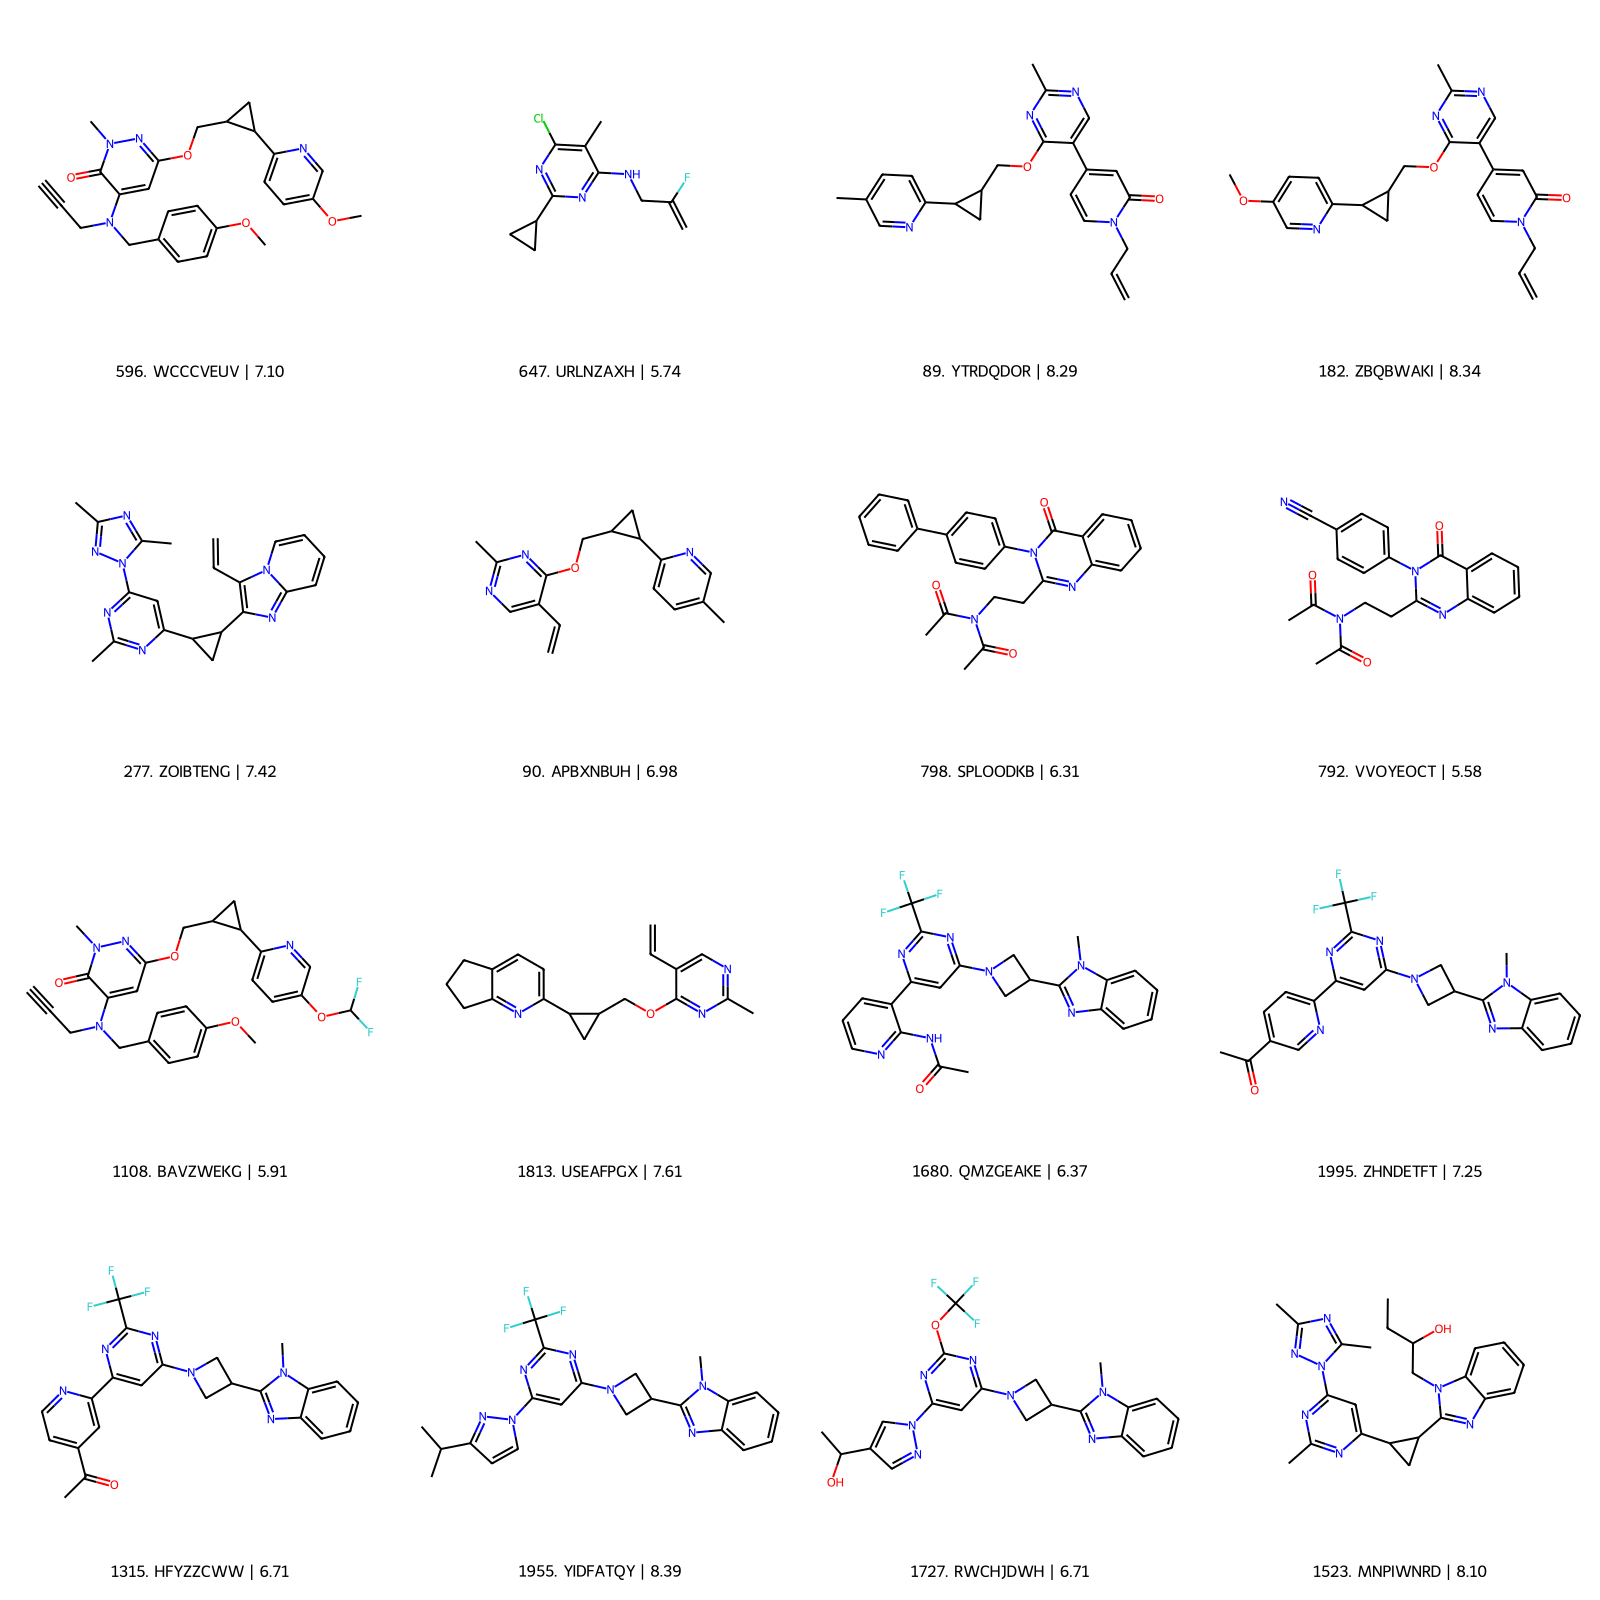

In [50]:

show_top_aug_vs_nonaug(output_df, n=8)